In [1]:
import os
from pcxarray import pc_query, prepare_data
from pcxarray.utils import load_census_shapefile
from distributed import Client
import matplotlib.pyplot as plt

In [2]:
states_gdf = load_census_shapefile(level='state', verify=False)
ms_gdf = states_gdf[states_gdf['NAME'] == 'Mississippi']
ms_gdf = ms_gdf.to_crs(epsg=3814)
geom = ms_gdf.geometry.union_all()

Found 10 items in the GNATSGO collection.


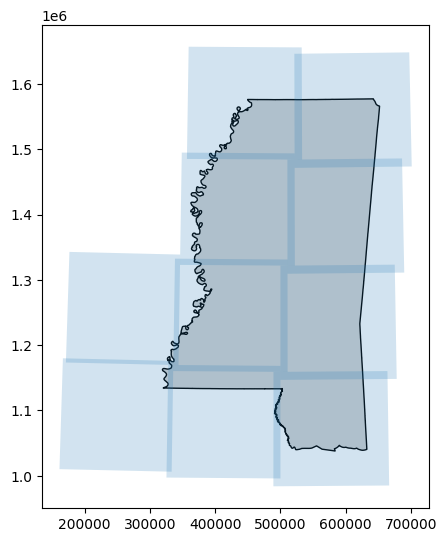

In [3]:
items_gdf = pc_query(
    collections='gnatsgo-rasters',
    geometry=geom,
    crs=ms_gdf.crs,
)
print(f"Found {len(items_gdf)} items in the GNATSGO collection.")

fig, ax = plt.subplots(figsize=(5, 10))
ms_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')
items_gdf.plot(ax=ax, alpha=0.2)
plt.show()

In [4]:
# These rasters are large, so a higher memory limit is required.
client = Client(n_workers=os.cpu_count(), memory_limit='8GB')
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 24,Total memory: 178.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42469,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35831,Total threads: 1
Dashboard: http://127.0.0.1:35623/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:42459,


In [5]:
nccpi_da = prepare_data(
    items_gdf,
    geometry=geom,
    crs=ms_gdf.crs,
    bands=['nccpi3corn', 'nccpi3cot', 'nccpi3soy'],
    target_resolution=100, # 100 m resolution
    resampling_method='bilinear',
    chunks={'x': 4096, 'y': 4096},
    max_workers=-1,
    enable_progress_bar=True,
)
display(nccpi_da)
nccpi_da = nccpi_da.compute()

Constructing dask computation graph: 100%|██████████| 10/10 [00:00<00:00, 866.91tiles/s]


<xarray.DataArray 'reproject-ea3e7959e7db4372a121f20b2a6d5c0b' (band: 3,
                                                                y: 5393, x: 3325)> Size: 215MB
dask.array<rechunk-merge, shape=(3, 5393, 3325), dtype=float32, chunksize=(1, 4096, 3325), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U10 120B 'nccpi3corn' 'nccpi3cot' 'nccpi3soy'
  * y            (y) float64 43kB 1.578e+06 1.578e+06 ... 1.039e+06 1.039e+06
  * x            (x) float64 27kB 3.186e+05 3.186e+05 ... 6.508e+05 6.51e+05
    spatial_ref  int32 4B 3814
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      National Commodity Crop Productivity Index for Corn (weig...
    _FillValue:     nan

/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 17.24 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


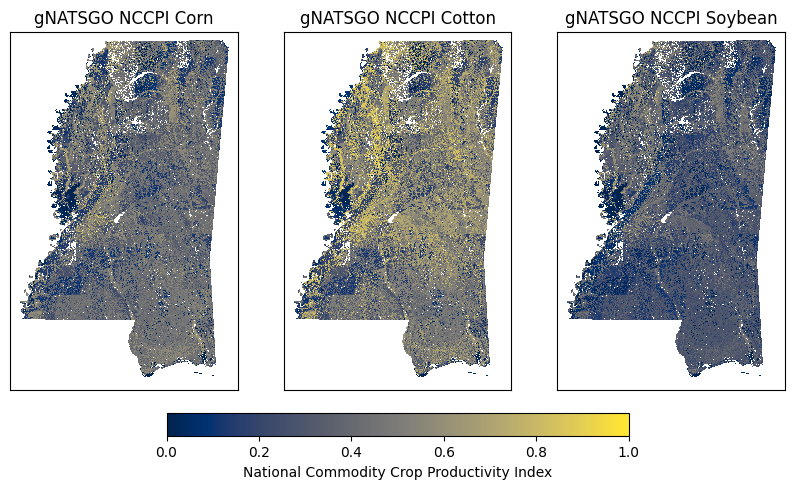

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(10, 15), sharex=True, sharey=True)

nccpi_da.sel(band='nccpi3corn').plot.imshow(ax=ax[0], cmap='cividis', vmin=0, vmax=1, add_colorbar=False)
nccpi_da.sel(band='nccpi3cot').plot.imshow(ax=ax[1], cmap='cividis', vmin=0, vmax=1, add_colorbar=False)
nccpi_da.sel(band='nccpi3soy').plot.imshow(ax=ax[2], cmap='cividis', vmin=0, vmax=1, add_colorbar=False)

for a in ax:
    a.set_aspect('equal')
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlabel('')
    a.set_ylabel('')
    
    # pad the axes to avoid overlap
    a.set_xlim(a.get_xlim()[0] - 5000, a.get_xlim()[1] + 5000)
    a.set_ylim(a.get_ylim()[0] - 5000, a.get_ylim()[1] + 5000)

ax[0].set_title('gNATSGO NCCPI Corn')

ax[1].set_title('gNATSGO NCCPI Cotton')

ax[2].set_title('gNATSGO NCCPI Soybean')

fig.colorbar(ax[0].images[0], ax=ax, orientation='horizontal', fraction=0.02, pad=0.02, label='National Commodity Crop Productivity Index')
plt.show()